Importing necessary libraries 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torchvision
from torchvision import datasets
import os
from pathlib import Path
import random
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms , datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from tqdm.auto import tqdm 
from timeit import default_timer as timer
from torch.autograd import Variable
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Version of Torch and Torchvision

In [2]:
print(f'The version of torch is : {torch.__version__}\nThe version of torchvision is : {torchvision.__version__}')

The version of torch is : 2.0.0
The version of torchvision is : 0.15.1


Looking at computer Hardware and GPU

In [3]:
!nvidia-smi

Fri Sep  1 14:22:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

If we have GPU we turn our device into that

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

creating a function to show details from folder 

In [5]:
def check_diractory(directory_path):
                                 
    for dirpath , dirname , filename in os.walk(directory_path):
        print(f"There are {len(dirname)} directories and {len(filename)} images in '{dirpath}'.")
        


Checking data path and its folders and images

In [6]:
d_Train = "/kaggle/input/intel-image-classification/seg_train"
d_Test = "/kaggle/input/intel-image-classification/seg_test"
d_pred = "/kaggle/input/intel-image-classification/seg_pred/seg_pred"
train_dir = d_Train + "/seg_train"
test_dir = d_Test + "/seg_test/"
prediction_dir = d_pred + '/seg_pred'

Checking Train directories and imges per class

In [7]:
Image_path_Train = Path(train_dir)
check_diractory(Image_path_Train)

There are 6 directories and 0 images in '/kaggle/input/intel-image-classification/seg_train/seg_train'.
There are 0 directories and 2512 images in '/kaggle/input/intel-image-classification/seg_train/seg_train/mountain'.
There are 0 directories and 2382 images in '/kaggle/input/intel-image-classification/seg_train/seg_train/street'.
There are 0 directories and 2191 images in '/kaggle/input/intel-image-classification/seg_train/seg_train/buildings'.
There are 0 directories and 2274 images in '/kaggle/input/intel-image-classification/seg_train/seg_train/sea'.
There are 0 directories and 2271 images in '/kaggle/input/intel-image-classification/seg_train/seg_train/forest'.
There are 0 directories and 2404 images in '/kaggle/input/intel-image-classification/seg_train/seg_train/glacier'.


Checking Test directories and imges per class

In [8]:
Image_path_Test = Path(test_dir)
check_diractory(Image_path_Test)

There are 6 directories and 0 images in '/kaggle/input/intel-image-classification/seg_test/seg_test'.
There are 0 directories and 525 images in '/kaggle/input/intel-image-classification/seg_test/seg_test/mountain'.
There are 0 directories and 501 images in '/kaggle/input/intel-image-classification/seg_test/seg_test/street'.
There are 0 directories and 437 images in '/kaggle/input/intel-image-classification/seg_test/seg_test/buildings'.
There are 0 directories and 510 images in '/kaggle/input/intel-image-classification/seg_test/seg_test/sea'.
There are 0 directories and 474 images in '/kaggle/input/intel-image-classification/seg_test/seg_test/forest'.
There are 0 directories and 553 images in '/kaggle/input/intel-image-classification/seg_test/seg_test/glacier'.


Determination of train - test - pred  paths

In [9]:
train_dir , test_dir , prediction_dir

('/kaggle/input/intel-image-classification/seg_train/seg_train',
 '/kaggle/input/intel-image-classification/seg_test/seg_test/',
 '/kaggle/input/intel-image-classification/seg_pred/seg_pred/seg_pred')

Showing a Random Image from Training images

The path   of the random image  is : /kaggle/input/intel-image-classification/seg_train/seg_train/forest/5087.jpg
The class  of the random image  is : forest
The height of the random image  is : 150
The width  of the random image  is : 150


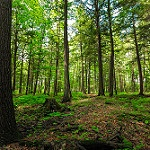

In [10]:
random.seed(42)

list_image_path = list(Path(train_dir).glob('*/*.jpg'))

Random_Image_Path = random.choice(list_image_path)

img = Image.open(Random_Image_Path)

print(f'The path   of the random image  is : {Random_Image_Path}')
print(f'The class  of the random image  is : {Random_Image_Path.parent.stem}')
print(f'The height of the random image  is : {img.height}')
print(f'The width  of the random image  is : {img.width}')
img

Using of data augmentation to avoid overfitting and fundamental converting  like from image to tensor  (there are various ways for Augmentation images)

In [11]:
train_transforms = transforms.Compose([
    transforms.Resize(size=(150 , 150)) ,
    transforms.ColorJitter(0.4,0.5,0.5,0.2),
    transforms.RandomHorizontalFlip(p=0.5) , 
    transforms.RandomCrop(size=(150,150)),  
    transforms.ToTensor(),
    transforms.Normalize((0.425, 0.415, 0.405), (0.205, 0.205, 0.205))
])


test_transforms = transforms.Compose([
    transforms.Resize((150, 150)), 
    transforms.ToTensor(),
    transforms.Normalize((0.425, 0.415, 0.405), (0.255, 0.245, 0.235))
])

Randomly showing orginal and transformed images

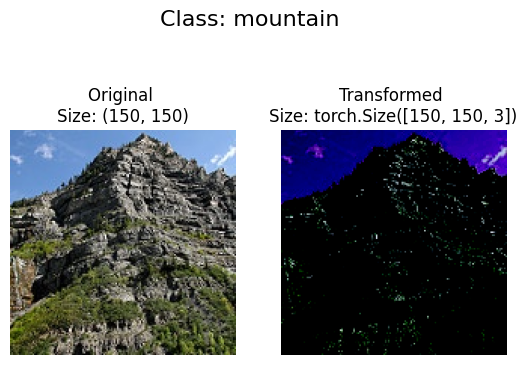

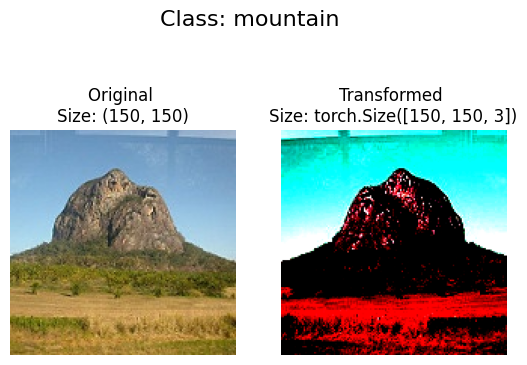

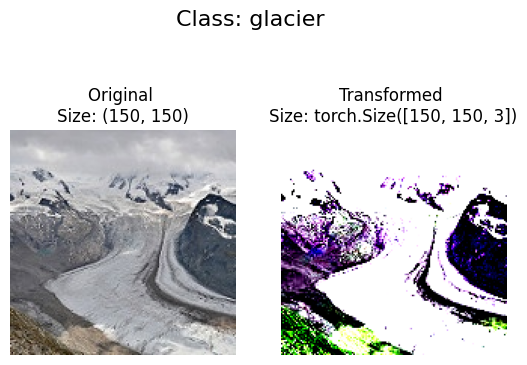

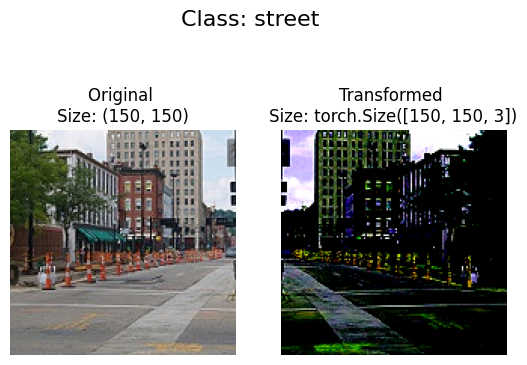

In [12]:
def show_transformed_images(path , transform , number=4 ,seed = 42):
    
    random.seed = seed
    random_image = random.sample(path , number)
    for path in random_image:
        with Image.open(path) as f :
            fig , ax = plt.subplots(1,2)      
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")
            
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")
            fig.suptitle(f"Class: {path.parent.stem}", fontsize=16)
            
show_transformed_images(path=list_image_path , 
                        transform=train_transforms, 
                        number=4)

ImageFolder is Responsible for loading images from train and test folders and setting transform on images

In [13]:
train_data = datasets.ImageFolder(root=train_dir , transform = train_transforms )
test_data = datasets.ImageFolder(root=test_dir , transform=test_transforms )
print(f'Train data : {train_data}\n\n\nTest data : {test_data}')

Train data : Dataset ImageFolder
    Number of datapoints: 14034
    Root location: /kaggle/input/intel-image-classification/seg_train/seg_train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=warn)
               ColorJitter(brightness=(0.6, 1.4), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=(-0.2, 0.2))
               RandomHorizontalFlip(p=0.5)
               RandomCrop(size=(150, 150), padding=None)
               ToTensor()
               Normalize(mean=(0.425, 0.415, 0.405), std=(0.205, 0.205, 0.205))
           )


Test data : Dataset ImageFolder
    Number of datapoints: 3000
    Root location: /kaggle/input/intel-image-classification/seg_test/seg_test/
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.425, 0.415, 0.405), std=(0.255, 0.245, 0.235))
   

Craeting a function to show classes and convert them into indexes for each

In [14]:
def class_finder(directory):
    classes = sorted(i.name for i in os.scandir(directory) if i.is_dir())
    if not classes:
        raise FileNotFound(f'This directory dose not have any classes : {directory}')
    class_to_inx = {name : value for name , value in enumerate(classes) }
    
    return  classes , class_to_inx



We create a class to show classes , indexes , length , showing image of dataset and etc

In [15]:
class ImageFolderCustom(Dataset):
    
    
    def __init__(self , target_dir , transform ):
        
        self.paths = list(Path(target_dir).glob('*/*.jpg'))
        
        self.transform = transform
        
        self.classes , self.classes_to_inx = class_finder(target_dir)
    
    def load_image(self, index):
        
        image_path = self.paths[index]
        
        return Image.open(image_path)
    
    
    def __len__(self):
        
        return len(self.paths)
    
    
    
    def __getitem__(self , indx):
        
        img = self.load_image(indx)
        
        class_name = self.paths[indx].parent.name
        
        class_inx = self.class_to_idx[class_name]
        
        if self.transform:
            return self.transform(img), class_idx 
        else:
            return img, class_idx 
        
        

Using ImageFolderCustom to convert Train and Test

In [16]:
train_data_custom = ImageFolderCustom(target_dir=train_dir, 
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(target_dir= test_dir, 
                                     transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x78df392a7be0>,
 <__main__.ImageFolderCustom at 0x78df31dcaf80>)

In [17]:
print(f'The len of train data is : {len(train_data_custom)}\nThe len of test  data is : {len(test_data_custom)}')

The len of train data is : 14034
The len of test  data is : 3000


Showing a random image

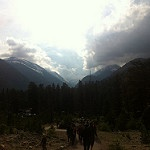

In [18]:
train_data_custom.load_image(100)

showing the number of classes and their names

In [19]:
print(f'The number of classes are : {len(train_data_custom.classes)}')
train_data_custom.classes


The number of classes are : 6


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

We infer each class to an index 

In [20]:
train_data_custom.classes_to_inx

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

seting 10 percent of Training data as validation (we use shuffle to make both Train and Validation randomly)

In [21]:
size_valid = 0.10

number_train = len(train_data_custom)
indx = list(range(number_train))

np.random.shuffle(indx)
split = int(size_valid * number_train)

train_idx, valid_idx = indx[split:], indx[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

Dataloader is used to make our data iterable for our model(we can set batch-size based on our computer power)

In [22]:
train_dataloader = DataLoader(dataset= train_data , 
                              batch_size= 32 ,  
                              num_workers=0,
                              sampler=train_sampler  
                              )
                             
valid_dataloader = DataLoader(dataset=train_data , 
                             batch_size=32 , 
                             num_workers=0,
                             sampler=valid_sampler                            
                             )

test_dataloader = DataLoader(dataset=test_data,
                            batch_size=32,
                            num_workers=0,
                            shuffle=False)

shape and size of a batch of train_dataloader

In [23]:
img , label = next(iter(train_dataloader))
# img
print(f'The shape is : {img.shape} [batch-size , color-channels , height , width]')
print(f'The label shape is : {label.shape}')

The shape is : torch.Size([32, 3, 150, 150]) [batch-size , color-channels , height , width]
The label shape is : torch.Size([32])


Using Pretraind Resnet50 and fication its gradient and changing last layer(from1000 classes into 6)

In [24]:
Model = torchvision.models.wide_resnet50_2(pretrained=True)

for param in Model.parameters():
    param.required_grad = False
    
number_feature = Model.fc.in_features
Model.fc = nn.Linear(in_features=number_feature , out_features=len(train_data.classes))

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth
100%|██████████| 132M/132M [00:00<00:00, 224MB/s]


Puting our model on GPU and showing its layers

In [25]:
Model.fc
Model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

Determination of Loss Function , Optimization and schedul learning(is a technique to reduce lr after a copule of epochs)

In [26]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=Model.parameters() , lr = 0.01)
schedul_learning = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer , milestones=[3 , 6 ] ,
                                                        gamma=0.055)

Summry function  helps us to check every detail of our model(you have to pip install  torchinfo first)

In [27]:
 
try :
    import torchinfo
except:
    !pip install torchinfo 
    import torchinfo
    
from torchinfo import summary   
summary(Model, input_size=[1, 3, 64, 64] )

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 6]                    --
├─Conv2d: 1-1                            [1, 64, 32, 32]           9,408
├─BatchNorm2d: 1-2                       [1, 64, 32, 32]           128
├─ReLU: 1-3                              [1, 64, 32, 32]           --
├─MaxPool2d: 1-4                         [1, 64, 16, 16]           --
├─Sequential: 1-5                        [1, 256, 16, 16]          --
│    └─Bottleneck: 2-1                   [1, 256, 16, 16]          --
│    │    └─Conv2d: 3-1                  [1, 128, 16, 16]          8,192
│    │    └─BatchNorm2d: 3-2             [1, 128, 16, 16]          256
│    │    └─ReLU: 3-3                    [1, 128, 16, 16]          --
│    │    └─Conv2d: 3-4                  [1, 128, 16, 16]          147,456
│    │    └─BatchNorm2d: 3-5             [1, 128, 16, 16]          256
│    │    └─ReLU: 3-6                    [1, 128, 16, 16]          --
│

Creating Train and Validation Loops for Model Learning 8 epochs 

In [28]:
st_time = timer()
epochs = 8


valid_loss_min = np.Inf
Valid_loss = []
Train_loss = []

for epoch in tqdm(range(1,epochs+1)):

    
    train_loss  = 0.0 
    valid_loss  = 0.0 

    #train
    Model.train()
    
    for batch , (X, y) in enumerate(train_dataloader):       
       
        
        X, y = X.to(device), y.to(device)
       
        optimizer.zero_grad()
       
        y_pred = Model(X)
       
        loss = loss_function(y_pred , y)
        
        
        loss.backward()
        
        optimizer.step()
        
        
        train_loss += loss.item()*X.size(0)
    

 
    #validation
    Model.eval()
    
    for batch , (X, y) in enumerate(valid_dataloader):
            
        X , y = X.to(device), y.to(device)
       
        y_pred = Model(X)
       
        loss = loss_function(y_pred, y)
       
        valid_loss += loss.item()*X.size(0)
  
        
       
    train_loss = train_loss/len(train_dataloader.sampler)
    valid_loss = valid_loss/len(valid_dataloader.sampler)
    Valid_loss.append(valid_loss)
    Train_loss.append(train_loss)
   
    schedul_learning.step()
    schedul_learning
    end_time = timer()
   
    print('Epoch: {} \nTraining Loss: {:.3f} \nValidation Loss: {:.3f}'.format(epoch, train_loss, valid_loss))
    
  
    if valid_loss <= valid_loss_min:
        
        print("Decrease Validation Loss {:.4f} : {:.4f} ".format(valid_loss_min, valid_loss))
        torch.save(Model.state_dict(), 'My_Model.pt')
        valid_loss_min = valid_loss
        
    print('Learning Rate : {:.4f}'.format(optimizer.state_dict()['param_groups'][0]['lr']))
    print('\nTime : {:.2f}'.format(end_time - st_time))
    print('----------------------------------')
    

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1 
Training Loss: 0.428 
Validation Loss: 0.216
Decrease Validation Loss inf : 0.2155 
Learning Rate : 0.0100

Time : 250.53
----------------------------------
Epoch: 2 
Training Loss: 0.219 
Validation Loss: 0.217
Learning Rate : 0.0100

Time : 404.06
----------------------------------
Epoch: 3 
Training Loss: 0.156 
Validation Loss: 0.195
Decrease Validation Loss 0.2155 : 0.1950 
Learning Rate : 0.0006

Time : 573.65
----------------------------------
Epoch: 4 
Training Loss: 0.114 
Validation Loss: 0.178
Decrease Validation Loss 0.1950 : 0.1779 
Learning Rate : 0.0006

Time : 710.91
----------------------------------
Epoch: 5 
Training Loss: 0.107 
Validation Loss: 0.179
Learning Rate : 0.0006

Time : 847.39
----------------------------------
Epoch: 6 
Training Loss: 0.104 
Validation Loss: 0.194
Learning Rate : 0.0000

Time : 981.43
----------------------------------
Epoch: 7 
Training Loss: 0.103 
Validation Loss: 0.186
Learning Rate : 0.0000

Time : 1116.23
---------------

Illustration of Train and Validation changes during each epoch

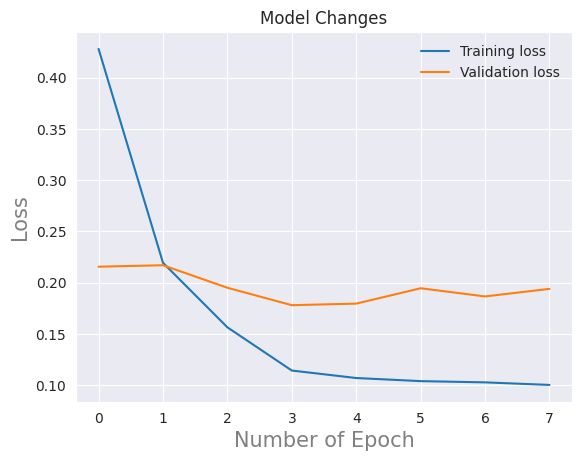

In [29]:
sns.set_style('darkgrid')
plt.plot(Train_loss, label='Training loss')
plt.plot(Valid_loss, label='Validation loss')
plt.legend(frameon=False)
plt.xlabel('Number of Epoch' , size = 15 , c = 'gray')
plt.ylabel('Loss' , size = 15 , c='gray')
plt.title('Model Changes')
plt.show()

Loading Model and put it on evaluation mode

In [30]:
Model.load_state_dict(torch.load('My_Model.pt'))
Model.eval()
Model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

Model Prediction

In [31]:
single_img, all_img = 0,0

for images, labels in test_dataloader:
    for i in range(len(labels)):
        images = images.cuda()
        labels = labels.cuda()
        img = images[i].view(1,3,150,150)
        
        with torch.no_grad():
            logps = Model(img)
            
        ps = torch.exp(logps)
        probab = list(ps.cpu()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.cpu()[i]
        if(true_label == pred_label):
            single_img += 1
        all_img += 1
        
print(f'There are {all_img} in test')
print(f'The model accuracy is :{round((single_img/all_img)*100  , 2)}')

There are 3000 in test
The model accuracy is :93.7


In [32]:
def pred_class(img):
    
    img_tens = test_transforms(img)
    img_im = img_tens.unsqueeze(0).cuda() 
    uinput = Variable(img_im)
    uinput = uinput.to(device)
    out = Model(uinput)
    index = out.data.cpu().numpy().argmax()    
    return index

Illustration of 50 pictures of prediction images

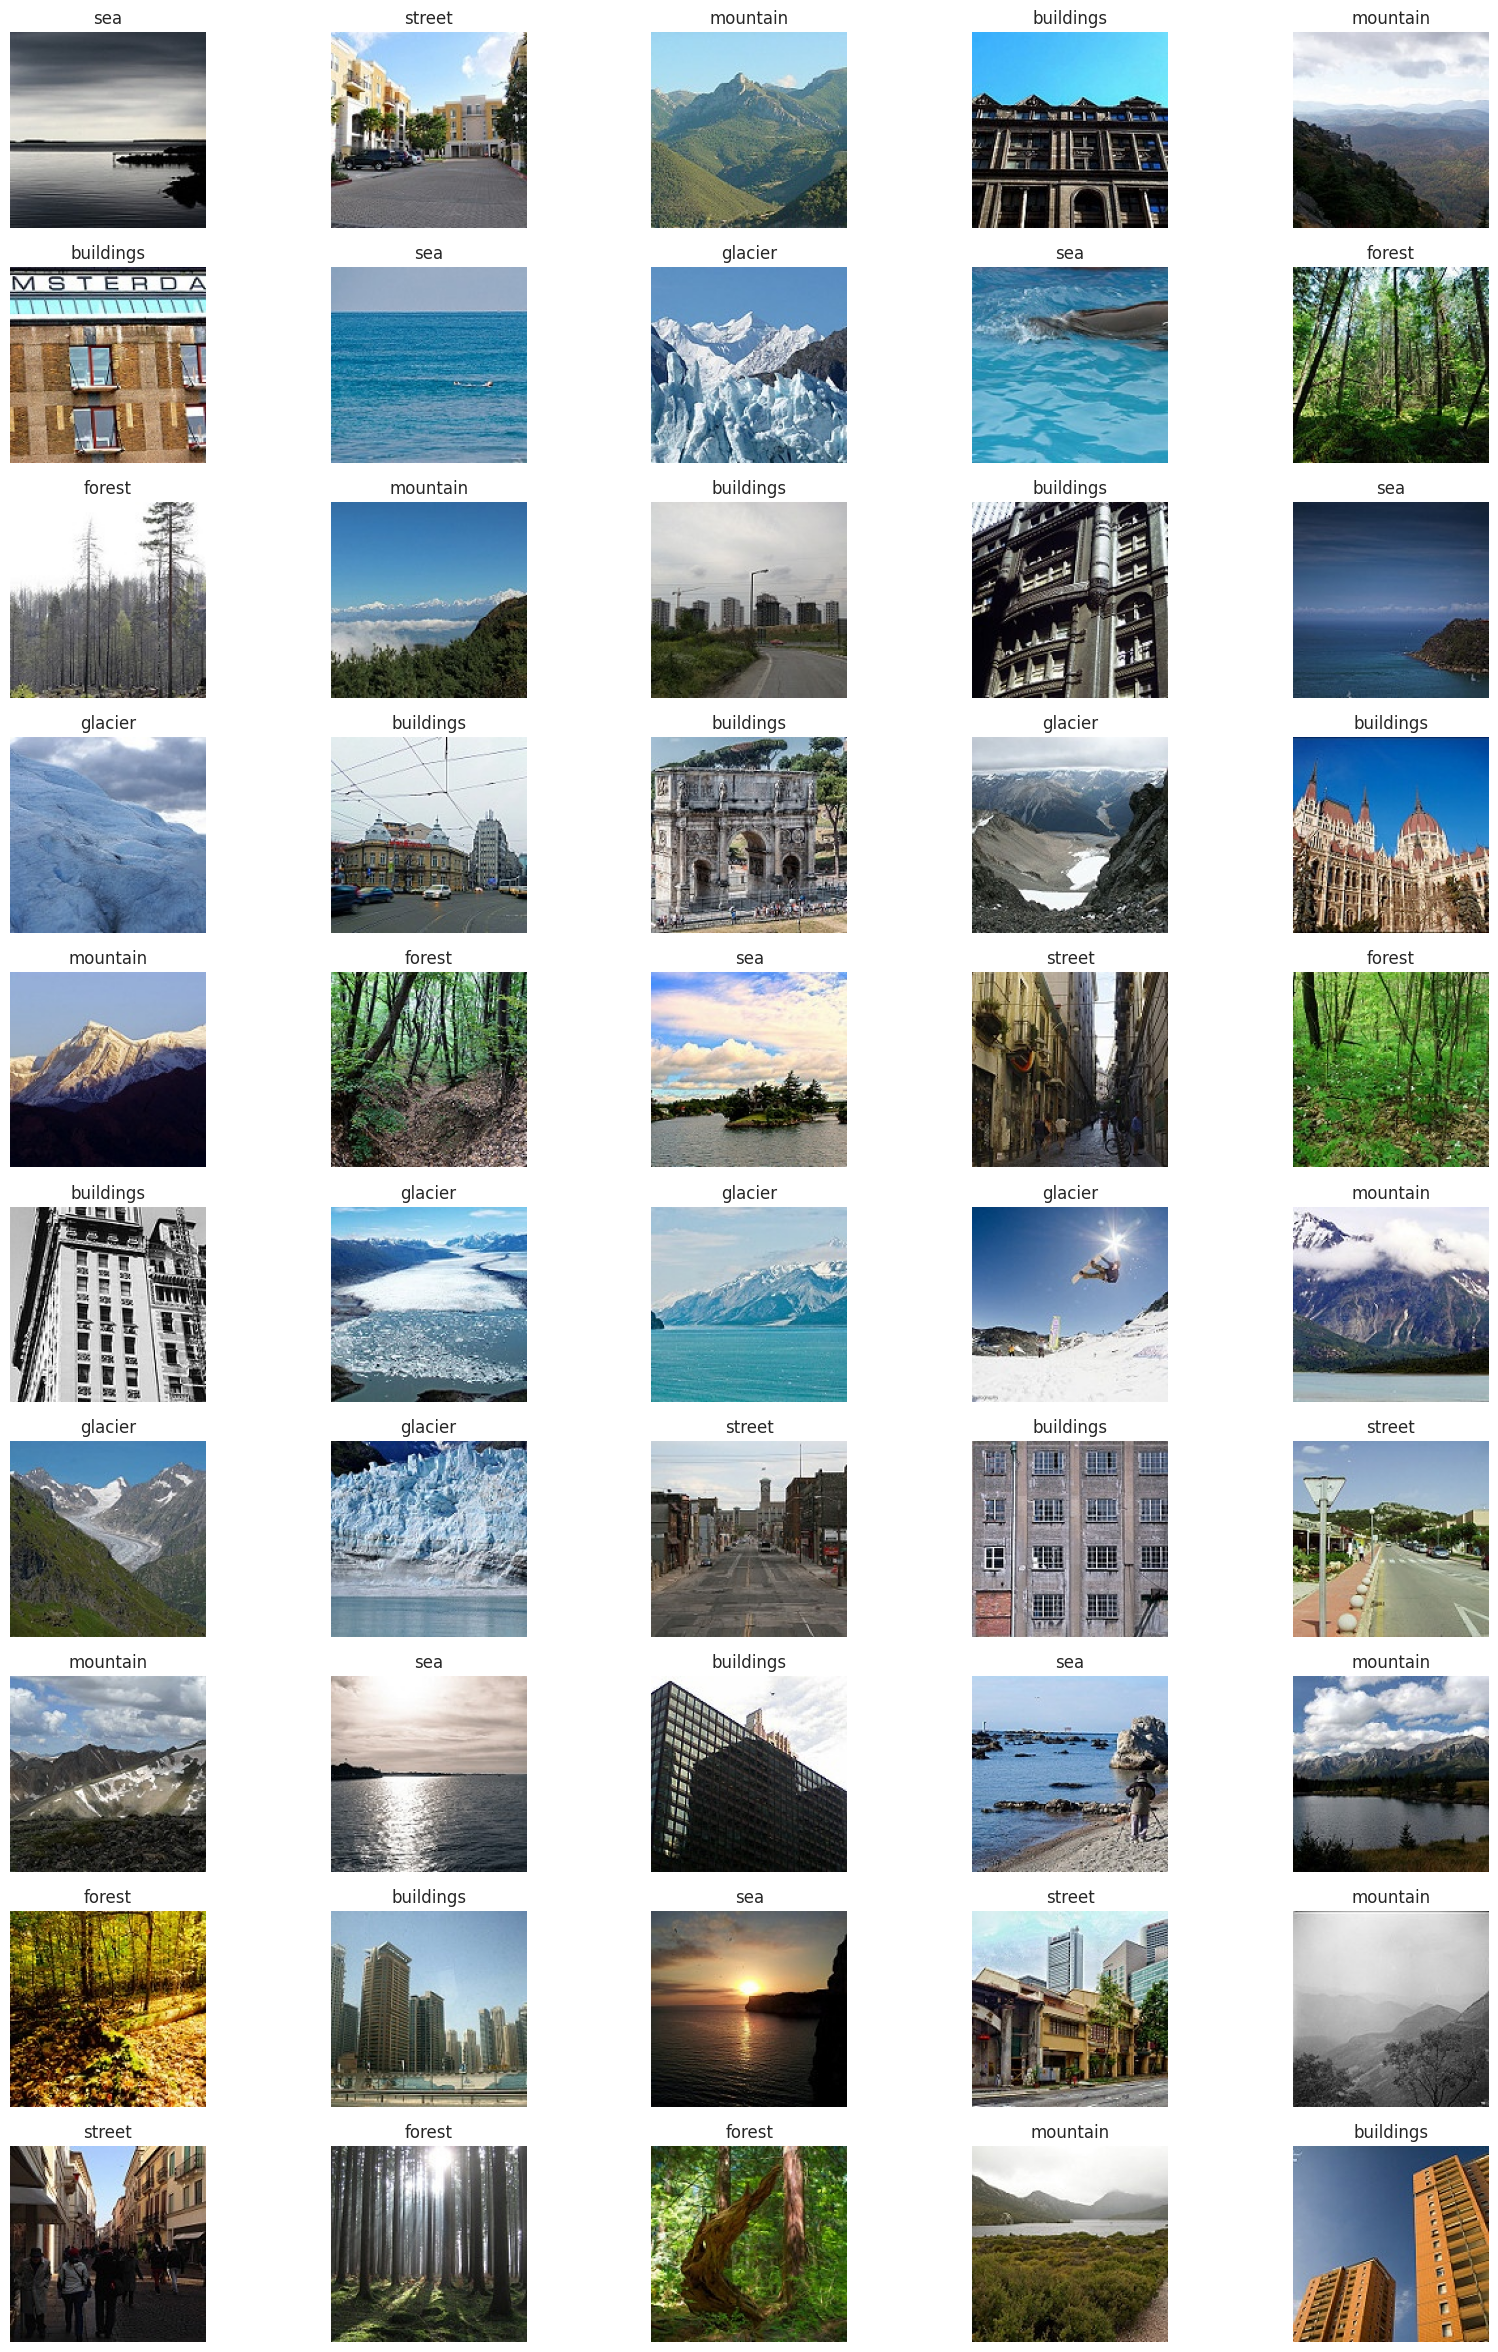

In [33]:
classes = {classes:values for classes , values in enumerate(sorted(train_data_custom.classes))}
Model.eval()

prediction_images = [os.path.join(d_pred, i)for i in os.listdir(d_pred)]
plt.figure(figsize=(20,30))
for i, images in enumerate(prediction_images):
    if i > 49 :break
    img = Image.open(images)
    index = pred_class(img)
    plt.subplot(10,5,i+1)
    plt.title(classes[index])
    plt.axis('off')
    plt.imshow(img)

If you liked Please upvote.Thank you